# Software profesional en Acústica 2024-25 (M2i)

*This notebook was adapted from Chapter 1 of [The FEniCS Tutorial Volume I](https://fenicsproject.org/pub/tutorial/sphinx1/) by Hans Petter Langtangen and Anders Logg, released under CC Attribution 4.0 license. It has been created by Xiangmin Jiao (University of Stony Brook University) and it is available in the repository [Unifem/FEniCS-note](https://github.com/unifem/fenics-notes).*

First, we need to install on the fly FEniCS 2019.1.0 using the [FEM on Colab](https://fem-on-colab.github.io/packages.html) install script:

In [16]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"

# The equations of vibrations in fluid-structure interaction (displacement formulation)

Vibrations in linear elasticity is the study of how solid objects are responding to a mechanical vibration and become 
internally stressed due to prescribed time-harmonic loading conditions. It is an important problem
in modern engineering. Its corresponding PDE is a generalization of the
Helmholtz equation, and it is among one of the most popular PDEs in 
engineering. We now study its variational formulation of a fluid-structure interaction and how to solve
this problem using FEniCS in 2D.

## PDE problem

The time-harmonic equation governing vibrations of a fluid-structure problem involving a elastic solid structure $\Omega_S$ and a fluid domain $\Omega_F$ can be written as
\begin{align}
\tag{1}
&-\omega^2\rho_S\boldsymbol{u}_S -\boldsymbol{\nabla}\cdot\boldsymbol{\sigma} = \boldsymbol{0}\hbox{ in }\Omega_S,\\
&-\omega^2\rho_F\boldsymbol{u}_F -\rho_Fc^2\nabla\mathrm{div}\boldsymbol{u}_F = \boldsymbol{0}\hbox{ in }\Omega_F,
\tag{2}
\end{align}

where $\boldsymbol{\sigma}$ is the *stress tensor*, $c$ is the sound speed in the fluid domain, $\boldsymbol{u}_S$ and $\boldsymbol{u}_F$ are the displacement fields in the solid anf fluid domain,
$\rho_S$ and $\rho_F$ are the *mass density* of the solid and fluid domain, and $\omega$ the angular frequency. For isotropic materials, the stress tensor is further related to the deformation by 
the following two equations:
\begin{align}
\boldsymbol{\sigma} &= \lambda\,\hbox{tr}\,(\boldsymbol{\varepsilon}) \boldsymbol{I} + 2\mu\boldsymbol{\varepsilon},
\tag{3}\\
\boldsymbol{\varepsilon} &= \frac{1}{2}\left(\boldsymbol{\nabla} \boldsymbol{u}_S + (\boldsymbol{\nabla} \boldsymbol{u}_S)^{\top}\right),
\tag{4}
\end{align}
where $\boldsymbol{\varepsilon}$ is the *symmetric strain-rate tensor* (symmetric gradient), 
and $\boldsymbol{u}$ is the *displacement vector field*, $\boldsymbol{I}$ denotes the *identity tensor*, 
$\mathrm{tr}$ denotes the *trace operator* on a tensor, and $\lambda$ and $\mu$ 
are material properties known as *Lamé's elasticity parameters*.

We can combine (3) and (4) to obtain
\begin{equation}
\tag{5}
\boldsymbol{\boldsymbol{\sigma}} = \lambda(\boldsymbol{\nabla}\cdot \boldsymbol{u}_S)\boldsymbol{I} + \mu(\boldsymbol{\nabla} \boldsymbol{u}_S + (\boldsymbol{\nabla} \boldsymbol{u}_S)^{\top})
\end{equation}

Note that
(3)-(5)
can easily be transformed to a single vector PDE for $\boldsymbol{u}_S$, which is the
governing PDE for the unknown $\boldsymbol{u}_S$ (Navier's equation).  In the
derivation of the variational formulation, however, it is convenient
to keep the equations split as above.

## Variational formulation

The variational formulation of (1)-(4)
consists of forming the inner product of (1)-(2) and two *vector* test functions
$(\boldsymbol{v}_F,\boldsymbol{v}_S)\in \hat{V}$, where $\hat{V}$ is a vector-valued test function space in $\Omega_F$ and $\Omega_S$ such that 
\begin{align}
\boldsymbol{v}_F\cdot \mathbf{n} = \boldsymbol{v}_S\cdot \mathbf{n},\\
\boldsymbol{\sigma}(\boldsymbol{u}_S)\mathbf{n} = -\rho_F c^2\mathrm{div}\boldsymbol{u}_{F}\mathbf{n},
\end{align}

on the coupling boundary $\Gamma_I=\partial\Omega_F\cap\partial\Omega_F$. So, integrating over the domain $\Omega_F\cup\Omega_S$ and taking into account the symmetry of the tensor of elasticity, it holds

\begin{align}
-\omega^2\int_{\Omega_S} \rho_S\boldsymbol{u}_S\cdot \boldsymbol{v}_S\ \mathrm{d}\boldsymbol{x}
 + \int_{\Omega_S} \boldsymbol{\sigma}(\boldsymbol{u}_S) : \boldsymbol{\epsilon}(\boldsymbol{v}_S)\ \mathrm{d}\boldsymbol{x} 
 -\omega^2\int_{\Omega_F} \rho_F\boldsymbol{u}_F\cdot \boldsymbol{v}_F\ \mathrm{d}\boldsymbol{x}
 + \int_{\Omega_F} \rho_F c^2\mathrm{div}\boldsymbol{v}_F\,\mathrm{div}\boldsymbol{v}_F \mathrm{d}\boldsymbol{x} 
 = \int_{\Gamma_T} \boldsymbol{T}\cdot \boldsymbol{v}_S\ \mathrm{d}\boldsymbol{s}
\tag{8}
\end{align}

for all $(\boldsymbol{v}_F,\boldsymbol{v}_S)\in \hat{V}$ such that $\boldsymbol{u}_S=\mathbf{0}$ on the campled boundary $\Gamma_C=\{\mathbf{x}\in\partial\Omega_{S}: x_0=0\}$ and the traction boundary $\Gamma_T=\{\mathbf{x}\in\partial\Omega_{S}: x_0=L\}$. In addition,
$\boldsymbol{\epsilon}(\boldsymbol{v})$ is the symmetric part of $\boldsymbol{\nabla} \boldsymbol{v}$.

### Enforcing boundary conditions

Now let us consider how to enforce boundary conditions. 
For Dirichlet boundaries, we will enforce boundary-conditions strongly.
For these points, no test functions are associated with the Dirichlet nodes.

For traction boundary conditions, we will enforce the boundary condition
weakly using the variational form (8).
Similar to the Helmholtz equation, we require their corresponding test
functions $\boldsymbol{v}_S$ vanish along $\Gamma_C$.
Then, the boundary integral above has no effects for points on
$\partial\Omega_S\setminus\Gamma_T$.

### Summary of variational form
In summary, the variational problem is to find $\boldsymbol{u}$ in a vector function space $\hat{V}$ such that
\begin{equation}
a((\boldsymbol{u}_F,\boldsymbol{u}_S),(\boldsymbol{v}_F,\boldsymbol{v}_S)) = L((\boldsymbol{v}_F,\boldsymbol{v}_S))\quad\forall (\boldsymbol{v}_F,\boldsymbol{v}_S)\in\hat{V},
\end{equation}
where 

\begin{align}
a((\boldsymbol{u}_F,\boldsymbol{u}_S),(\boldsymbol{v}_F,\boldsymbol{v}_S)) &= -\omega^2\int_{\Omega_S} \rho_S\boldsymbol{u}_S\cdot \boldsymbol{v}_S\ \mathrm{d}\boldsymbol{x}
 + \int_{\Omega_S} \boldsymbol{\sigma}(\boldsymbol{u}_S) : \boldsymbol{\epsilon}(\boldsymbol{v}_S)\ \mathrm{d}\boldsymbol{x} 
 -\omega^2\int_{\Omega_F} \rho_F\boldsymbol{u}_F\cdot \boldsymbol{v}_F\ \mathrm{d}\boldsymbol{x}
 + \int_{\Omega_F} \rho_F c^2\mathrm{div}\boldsymbol{v}_F\,\mathrm{div}\boldsymbol{v}_F \mathrm{d}\boldsymbol{x} 
\end{align}
and 
\begin{equation}
\boldsymbol{\sigma}(\boldsymbol{u}_S) = \lambda(\boldsymbol{\nabla}\cdot \boldsymbol{u}_S)\boldsymbol{I} + \mu(\boldsymbol{\nabla} \boldsymbol{u}_S + (\boldsymbol{\nabla} \boldsymbol{u}_S)^{\top}).\\
\end{equation}

## FEniCS implementation

To demonstrate the implementation, we will model a clamped beam deformed under a time-harmonic surface force on the opposite free cross-section surface. This can be modeled by setting $\boldsymbol{T}=(0,0,1)$ on that boundary $\Gamma_T$. The solid structure is box-shaped with length and width $L$, whereas the fluid domain is an interior box-shaped domain with length and width $W<L$. We
set $\boldsymbol{u}=(0,0,0)$ at the clamped end, $x=0$. The rest of the lateral boundary is
traction free; that is, we set $\boldsymbol{T} = 0$. Therefore,
$$L((\boldsymbol{v}_F,\boldsymbol{v}_S)) = \int_{\Gamma_T} \boldsymbol{T}\cdot \boldsymbol{v}_S \mathrm{d}\boldsymbol{s}$$
for this problem.

### Import packages

We start by importing fenics and enforcing matplotlib. In addition, we import `mshr` for mesh generation.

In [17]:
import numpy as np
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt

### Generate the mesh and function spaces

Our action startes by generating meshes and defining function spaces.

In [18]:
# Create mesh and define function space
length = 1; width = 1.
length_fluid = 0.6; width_fluid = 0.6

# Mesh
N = 8 # use positive integer values
mesh = RectangleMesh(Point(0, 0), Point(length, width), N*10, N*10, "right/left")
V = VectorFunctionSpace(mesh, 'P', 2)

To define the partition of the computational domain attending to the fluid and solid subdomains, each triangle of the finite element mesh is marked with a number flag or *marker*:

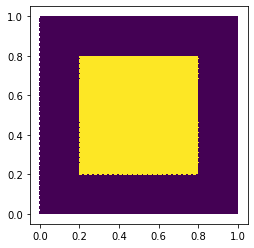

In [19]:
# Initialize subdomain and boundary markers
tol = 1e-5
fluid_domain = CompiledSubDomain('(fabs(x[0]-0.5) < L0/2. + tol) and (fabs(x[1]-0.5) < L1/2. + tol)', L0=length_fluid, L1=width_fluid, tol=tol)

# Initialize mesh function for boundary
domain_markers = MeshFunction('size_t', mesh, mesh.topology().dim())
domain_markers.set_all(1)
fluid_domain.mark(domain_markers, 2) 

# Define the boundary measure with the boundary markers
dx = Measure('dx', domain=mesh, subdomain_data=domain_markers)

plot(domain_markers)
plt.show()

### Define the variational problem

The primary unknown is now a vector field $\boldsymbol{u}$ and not a scalar field,
so we need to work with a vector function space. We will use 
piecewise-linear basis functions for all the components.


In [20]:
u = TrialFunction(V)
v = TestFunction(V)

With `u = TrialFunction(V)` we get `u` as a vector-valued finite element
function with three components for this 2D problem.

Next, we define the stress tensor and $a$. The gradient and divergence operators 
now have a prefix `nabla_`.
This is not strictly necessary in the present problem, but is
recommended in general for vector PDEs arising from continuum mechanics,
if you interpret $\boldsymbol{\nabla}$ as a vector in the PDE notation. See
the notes on `grad(u)` vs. `nabla_grad(u)` below.

In [21]:
from ufl_legacy import nabla_div

# Define strain and stress
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    #return sym(nabla_grad(u))

# Frequency
omega = 2*np.pi*1.0
    
# Physical constants for the solid   
rho_fluid = 0.2
c = 1.

# Physical constants for the solid
rho = 1.
beta = 1.25
lambda_ = beta
mu = 1
d = u.geometric_dimension()  # space dimension

def sigma(u):
    return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)

# Define a
a = -omega**2*rho*inner(u, v)*dx(1) + inner(sigma(u), epsilon(v))*dx(1) -omega**2*rho_fluid*inner(u, v)*dx(2) + rho_fluid*c**2*div(u)*div(v)*dx(2)

To define the partition of the boundary in the computational domain, each face of the finite element mesh is marked with a number flag or *marker*:

In [22]:
# Initialize subdomain and boundary markers
tol = 1e-5
clamped_boundary = CompiledSubDomain('on_boundary and near(x[0],L,tol)', L=0., tol=tol)
traction_boundary = CompiledSubDomain('on_boundary and near(x[0],L,tol)', L=length, tol=tol)

# Initialize mesh function for boundary
boundary_markers = MeshFunction('size_t', mesh, mesh.topology().dim() - 1)
boundary_markers.set_all(0)
clamped_boundary.mark(boundary_markers, 1) 
traction_boundary.mark(boundary_markers, 2)

# Define the boundary measure with the boundary markers
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

To define $L$, $\boldsymbol{f}=(0, 0, 1)$ is a constant vector, instead of a scalar.
Such a vector constant is specified as `Constant(0, 0, 1)` in FEniCS.

In [23]:
# Define L
f = Constant((0, 1))
L = dot(f, v)*ds(2)

### Define boundary conditions

We only specify the Dirichlet boundary condition. For the boundary condition 
$u=(0, 0, 0)$, we must set a vector value to zero, not just a scalar. 
We specify the vector constant as `Constant((0, 0, 0))`.

In [24]:
# Define boundary condition
bc = DirichletBC(V, Constant((0, 0)), boundary_markers, 1)

### Solve the variational problem

Finally, we can solve the problem.

In [25]:
# Compute solution
u = Function(V)
solve(a == L, u, bc)

### Plot the solution

Any component of the solution can be computed or even the modulus of the vector-field solution

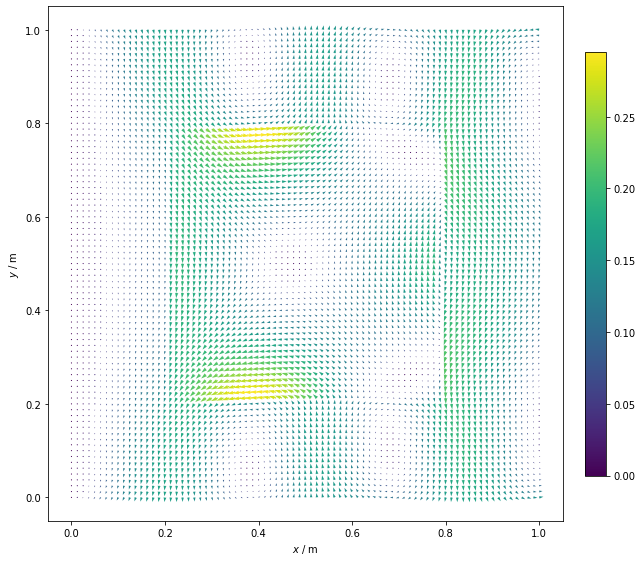

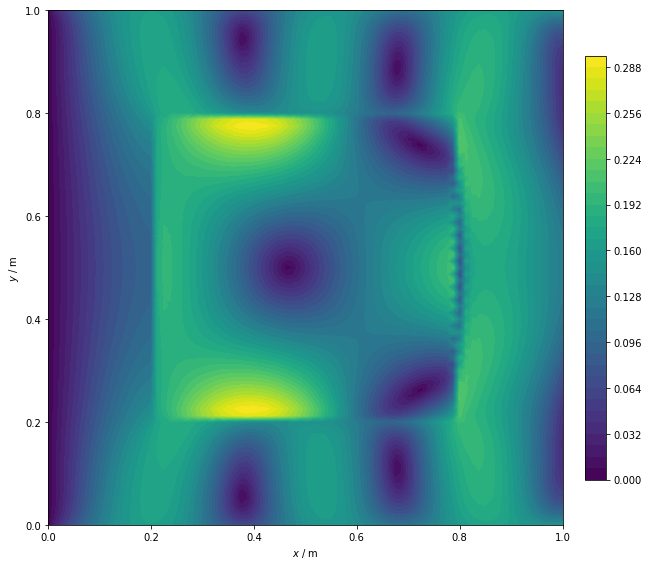

In [26]:
# Plot the Finite Element approximation
def plot_solution(u):
    '''plot solution of FEM-based simulation'''
    fig = plt.figure(figsize=(10,10))
    fig = plot(u)
    plt.xlabel(r'$x$ / m')
    plt.ylabel(r'$y$ / m')
    plt.colorbar(fig, fraction=0.038, pad=0.04);
    
# Plot vector field   
plot_solution(u)

# Compute magnitude of displacement
u_magnitude = sqrt(dot(u, u))
Q = FunctionSpace(mesh, 'P', 2)
u_magnitude = project(u_magnitude, Q)
plot_solution(u_magnitude)

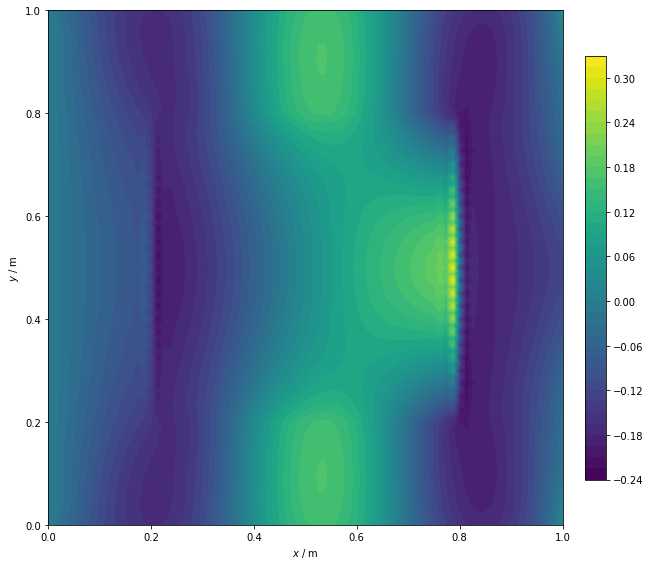

In [27]:
# Plot second component of the solution
plot_solution(u[1])

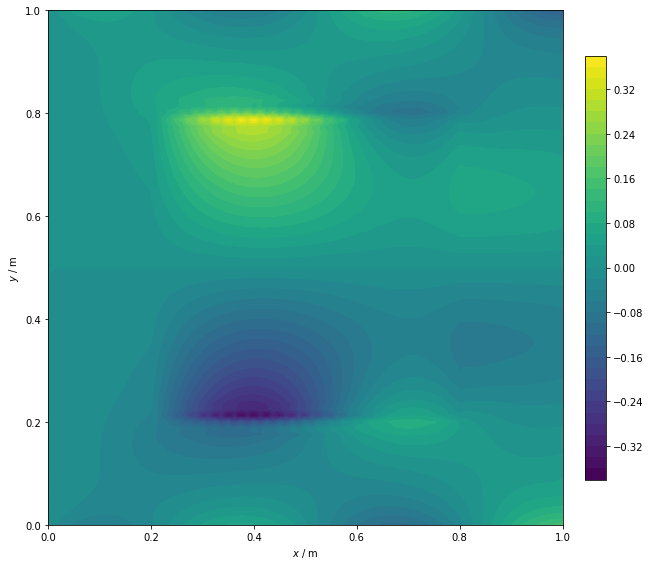

In [28]:
# Plot first component of the solution
plot_solution(u[0])